# Task 2
This serves as a template which will guide you through the implementation of this task. It is advised to first read the whole template and get a sense of the overall structure of the code before trying to fill in any of the TODO gaps.
This is the jupyter notebook version of the template. For the python file version, please refer to the file `template_solution.py`.

First, we import necessary libraries:

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Add any other imports you need here

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, RBF, Matern, RationalQuadratic

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, BiScaler, MatrixFactorization

from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer


# Data Loading
TODO: Perform data preprocessing, imputation and extract X_train, y_train and X_test
(and potentially change initialization of variables to accomodate how you deal with non-numeric data)

In [2]:
"""
This loads the training and test data, preprocesses it, removes the NaN
values and interpolates the missing data using imputation

Parameters
----------
Compute
----------
X_train: matrix of floats, training input with features
y_train: array of floats, training output with labels
X_test: matrix of floats: dim = (100, ?), test input with features
"""
# Load training data
train_df = pd.read_csv("train.csv")
    
print("Training data:")
print("Shape:", train_df.shape)
print(train_df.head(2))
print('\n')
    
# Load test data
test_df = pd.read_csv("test.csv")

print("Test data:")
print(test_df.shape)
print(test_df.head(2))

# Dummy initialization of the X_train, X_test and y_train   
# TODO: Depending on how you deal with the non-numeric data, you may want to 
# modify/ignore the initialization of these variables   
X_train = np.zeros_like(train_df.drop(['price_CHF'],axis=1))
y_train = np.zeros_like(train_df['price_CHF'])
X_test = np.zeros_like(test_df)

# TODO: Perform data preprocessing, imputation and extract X_train, y_train and X_test

assert (X_train.shape[1] == X_test.shape[1]) and (X_train.shape[0] == y_train.shape[0]) and (X_test.shape[0] == 100), "Invalid data shape"

Training data:
Shape: (900, 11)
   season  price_AUS  price_CHF  price_CZE  price_GER  price_ESP  price_FRA  \
0  spring        NaN   9.644028  -1.686248  -1.748076  -3.666005        NaN   
1  summer        NaN   7.246061  -2.132377  -2.054363  -3.295697  -4.104759   

   price_UK  price_ITA  price_POL  price_SVK  
0 -1.822720  -3.931031        NaN  -3.238197  
1 -1.826021        NaN        NaN  -3.212894  


Test data:
(100, 10)
   season  price_AUS  price_CZE  price_GER  price_ESP  price_FRA  price_UK  \
0  spring        NaN   0.472985   0.707957        NaN  -1.136441 -0.596703   
1  summer  -1.184837   0.358019        NaN  -3.199028  -1.069695       NaN   

   price_ITA  price_POL  price_SVK  
0        NaN   3.298693   1.921886  
1  -1.420091   3.238307        NaN  


[-0.4385864039966543, -1.2849004433189135, -0.11146420511990907, -0.26671769755860164, -0.012477207199162565]
[-3.3050941253040866, -1.0667147693759227, -0.3479632523194969, -0.5580834915723081, -0.06973792363885134]
[-1.6177740822647486, -2.4431387566191307, -0.26596268177612714, -0.2757783024212441, -0.012689714857994083]
[-2.5994067484374503, -1.3006086384052646, -0.2979408781154711, -0.2952299422279443, -0.11004798250323344]
[-5.603443105733694, -4.191031606764436, -0.0043781720765769805, -0.7471837011455049, -0.0506609338950097]
[-1.4566654082074364, -0.18486010990008905, -0.42270372898995023, -0.2982740206286121, -0.17307280634830913]
[-20.701443530228133, -8.49126242089473, 0.017203741475152468, -1.9992972125990192, -0.01574937838073165]
[-1.7649138831573872, -0.4572255163499328, -0.28462383937329694, -0.5707598704294616, -0.015986934275013187]
[-2.5127931258566076, -0.9327143960952327, -0.3837525365653527, -0.36508172305144737, -0.04741810440132155]
[-1.0737193235019382, -1.299

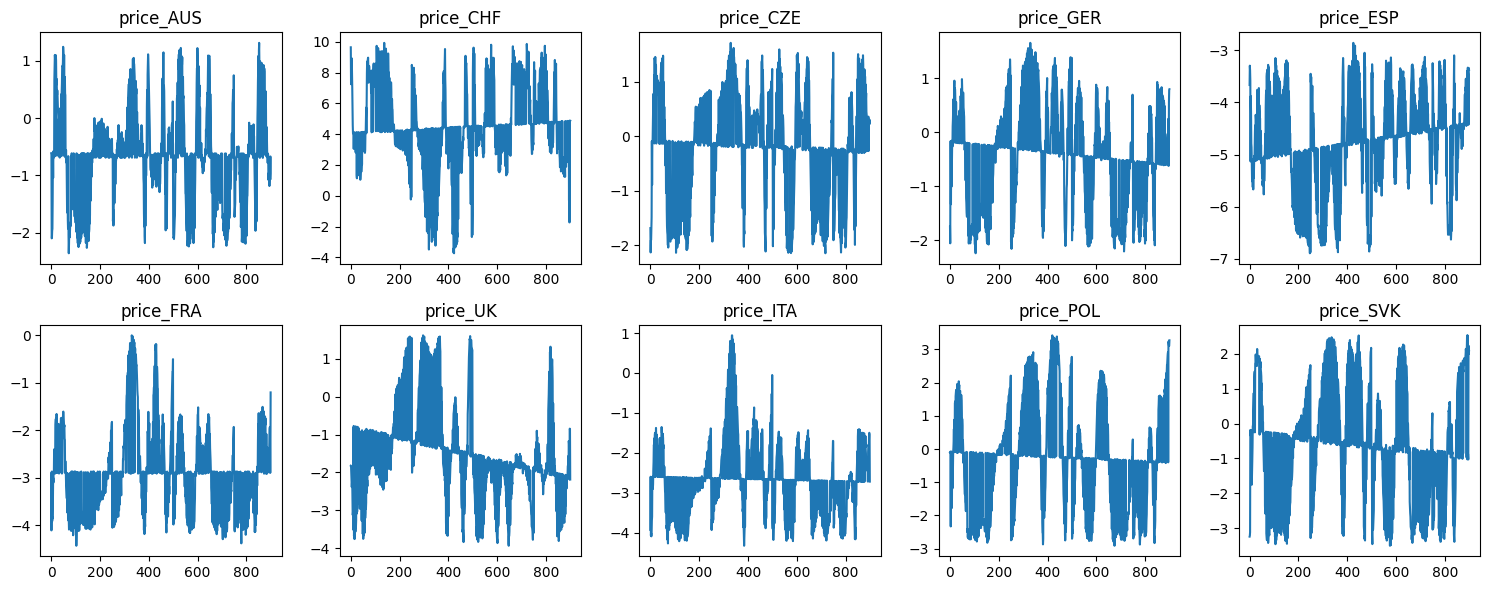

In [3]:
#Linear model imputation

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score



seasons_to_numbers = np.array([0, 1, 2, 3])
length = 900  
numbers_rep = np.tile(seasons_to_numbers, length // len(seasons_to_numbers) + 1)[:length] #an array [0 1 2 3 0 1 2 3 ... ] for the seasons
numbers_rep = pd.Series(numbers_rep, name='Seasons to Numbers') #making a pd type 

chron = pd.Series(np.arange(length), name = 'Time') #assuming the seasons are in chronological order 

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()

i = 0 
for country in train_df.columns: 
    if str(country) != 'season': 

        dfc = pd.concat([chron, numbers_rep, train_df[str(country)]], axis=1) #making a big matrix of time, seasons and prices

        c = [c for c in dfc.columns if c != str(country)]
        X = dfc[dfc[str(country)].notnull()].loc[:, c].values #the non-missing time and seasons
        y = dfc[dfc[str(country)].notnull()][str(country)].values #the non-missing prices 
        missing_prices = dfc[dfc[str(country)].isnull()].loc[:, c].values #the missing prices 

        kf = KFold(n_splits=5)
        scores = [] #measures how much better than baseline linear regression performs, where baseline is flat regression against the mean. In this case that baseline performance (an  R2 of 0) is the performance of replacing the missing values with the mean of the observed values.
        predicted_prices = []

        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            clf = LinearRegression()
            clf.fit(X_train, y_train)
            y_test_pred = clf.predict(X_test)
            
            scores.append(r2_score(y_test, y_test_pred))

            y_missing_pred = clf.predict(missing_prices)
            predicted_prices.append(y_missing_pred)


        print(scores)
        mean_predicted_prices = np.mean(predicted_prices, axis=0)
        dfc.loc[dfc[str(country)].isnull(), str(country)] = mean_predicted_prices
        #plt.plot(dfc[str(country)])
        #plt.title(str(country))
        #plt.show()

        axs[i].plot(dfc[str(country)])
        axs[i].set_title(str(country))
        i = i+1 

plt.tight_layout()
plt.show()




[-0.1664905503480434, -0.9943838498972133, -0.11213883071741315, -0.18688681804944474, -0.0004053332677458332]
[-0.8365423538892662, -0.9421726760403222, -0.3500164721856047, -0.45598387660570383, -0.07048840720965899]
[-0.43446699832481883, -2.03258616429289, -0.26388219381417466, -0.2142565003106338, -0.014066716744582708]
[-0.50702652554497, -1.230173549304023, -0.29619526271049246, -0.29598840191220166, -0.14091890764169945]
[-0.8336519180489521, -3.8389211351902732, -0.0009325180908197339, -0.8386554886152615, -0.0205082042734388]
[-0.5218815271096711, -0.16676010519160211, -0.4224017411472978, -0.20330597132671402, -0.062258646779696614]
[-2.1939491067652748, -8.24843724254208, -0.0055864883049363545, -2.6456830233182185, -0.26958354873388846]
[-0.5468050367330659, -0.4061254712016198, -0.2851785278794703, -0.4433655777285037, -0.017164413918281385]
[-0.6832402904350174, -0.8122313772191261, -0.38480630791624804, -0.28838743121086585, -0.04480946004137243]
[-0.20386271742344397, 

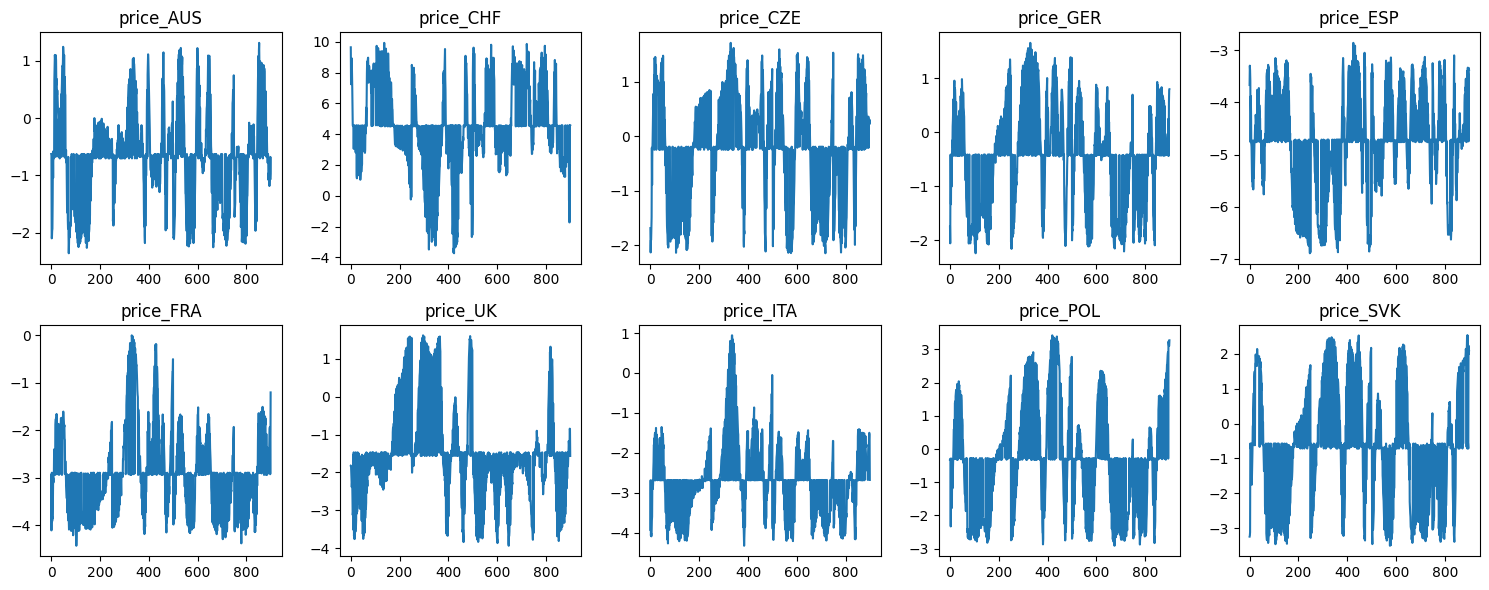

In [4]:
#linear imputation, without time variable 

#Linear model imputation

seasons_to_numbers = np.array([0, 1, 2, 3])
length = 900  
numbers_rep = np.tile(seasons_to_numbers, length // len(seasons_to_numbers) + 1)[:length] #an array [0 1 2 3 0 1 2 3 ... ] for the seasons
numbers_rep = pd.Series(numbers_rep, name='Seasons to Numbers') #making a pd type 

chron = pd.Series(np.arange(length), name = 'Time') #assuming the seasons are in chronological order 
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()

i = 0 
for country in train_df.columns: 
    if str(country) != 'season': 

        dfc = pd.concat([ numbers_rep, train_df[str(country)]], axis=1) #making a big matrix of time, seasons and prices

        c = [c for c in dfc.columns if c != str(country)]
        X = dfc[dfc[str(country)].notnull()].loc[:, c].values #the non-missing time and seasons
        y = dfc[dfc[str(country)].notnull()][str(country)].values #the non-missing prices 
        missing_prices = dfc[dfc[str(country)].isnull()].loc[:, c].values #the missing prices 

        kf = KFold(n_splits=5)
        scores = [] #measures how much better than baseline linear regression performs, where baseline is flat regression against the mean. In this case that baseline performance (an  R2 of 0) is the performance of replacing the missing values with the mean of the observed values.
        predicted_prices = []

        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            clf = LinearRegression()
            clf.fit(X_train, y_train)
            y_test_pred = clf.predict(X_test)
            
            scores.append(r2_score(y_test, y_test_pred))

            y_missing_pred = clf.predict(missing_prices)
            predicted_prices.append(y_missing_pred)


        print(scores)
        mean_predicted_prices = np.mean(predicted_prices, axis=0)
        dfc.loc[dfc[str(country)].isnull(), str(country)] = mean_predicted_prices
        #plt.plot(dfc[str(country)])
        #plt.title(str(country))
        #plt.show()

        axs[i].plot(dfc[str(country)])
        axs[i].set_title(str(country))
        i = i+1 

plt.tight_layout()
plt.show()




Imputing row 1/11 with 0 missing, elapsed time: 0.001


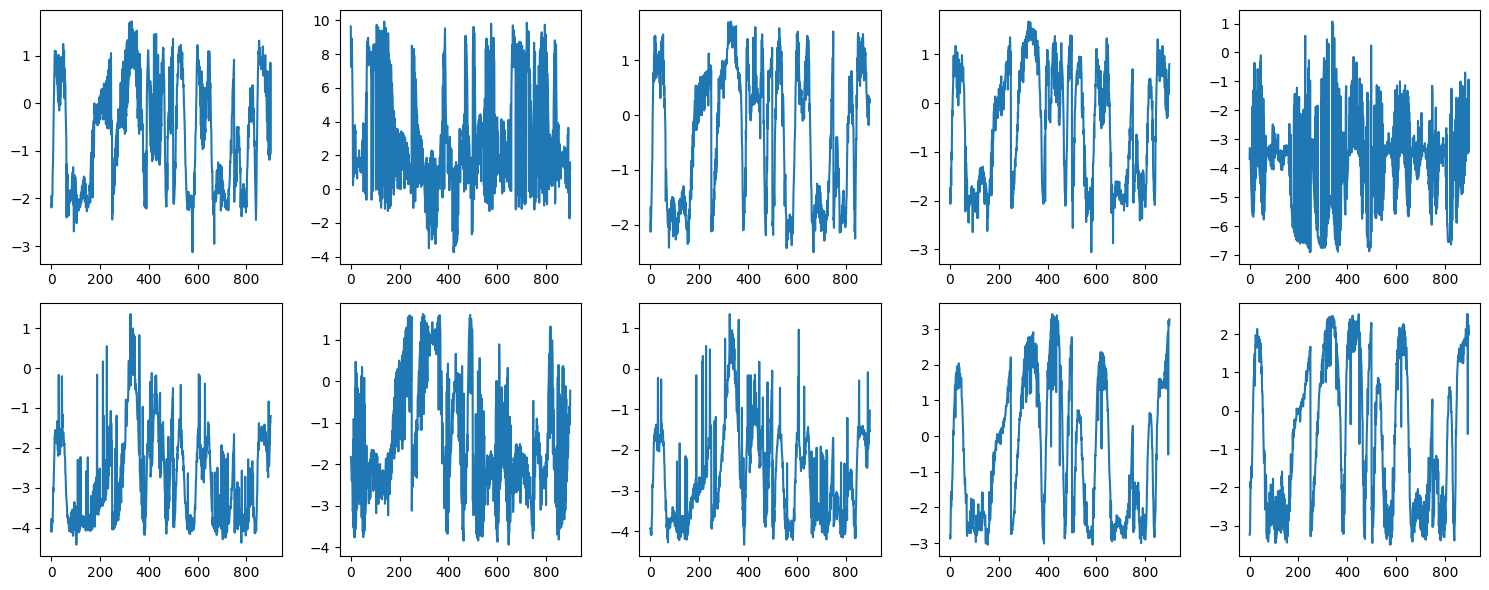

In [14]:
train_df = pd.read_csv("train.csv")
#train_df = train_df.drop(columns=['season'])
train_df['season']=train_df['season'].map({'spring':0.0, 'summer':1.0, 'autumn':2.0, 'winter':3.0})
#test_df['season']=test_df['season'].map({'spring':0.0, 'summer':1.0, 'autumn':2.0, 'winter':3.0})

train_df = train_df.transpose()
X_filled_knn = KNN(k=4).fit_transform(train_df)

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()

X_filled_knn = X_filled_knn[1:]
for i in range(10):
    axs[i].plot(X_filled_knn[i])

X_filled_knn = pd.DataFrame(X_filled_knn)   
plt.tight_layout()
plt.show()




[SoftImpute] Max Singular Value of X_init = 192.336998
[SoftImpute] Iter 1: observed MAE=0.118422 rank=11
[SoftImpute] Iter 2: observed MAE=0.118955 rank=11
[SoftImpute] Iter 3: observed MAE=0.119473 rank=11
[SoftImpute] Iter 4: observed MAE=0.119968 rank=11
[SoftImpute] Iter 5: observed MAE=0.120453 rank=11
[SoftImpute] Iter 6: observed MAE=0.120940 rank=11
[SoftImpute] Iter 7: observed MAE=0.121393 rank=11
[SoftImpute] Iter 8: observed MAE=0.121788 rank=11
[SoftImpute] Iter 9: observed MAE=0.122133 rank=11
[SoftImpute] Iter 10: observed MAE=0.122430 rank=11
[SoftImpute] Iter 11: observed MAE=0.122658 rank=11
[SoftImpute] Iter 12: observed MAE=0.122819 rank=11
[SoftImpute] Iter 13: observed MAE=0.122920 rank=11
[SoftImpute] Iter 14: observed MAE=0.122968 rank=11
[SoftImpute] Iter 15: observed MAE=0.122975 rank=11
[SoftImpute] Iter 16: observed MAE=0.122951 rank=11
[SoftImpute] Iter 17: observed MAE=0.122911 rank=11
[SoftImpute] Iter 18: observed MAE=0.122860 rank=11
[SoftImpute] Iter 

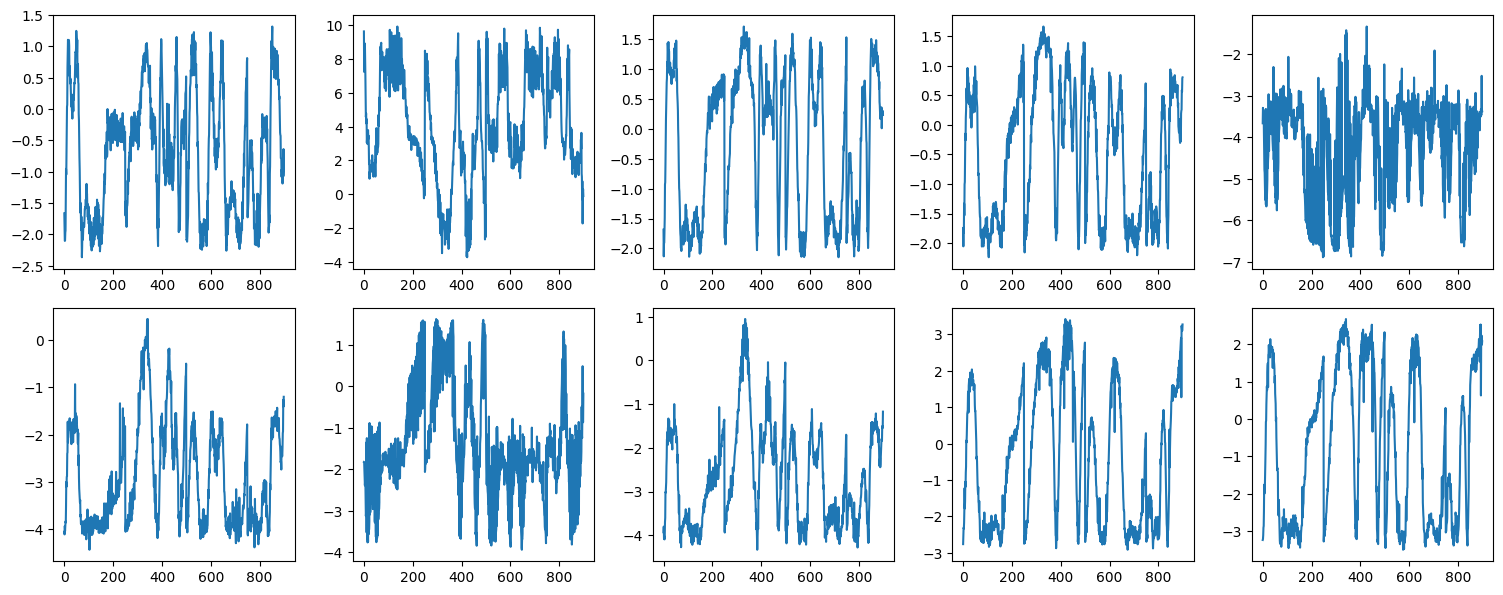

In [15]:
#soft impute 

train_df = pd.read_csv("train.csv")
#train_df = train_df.drop(columns=['season'])
train_df['season']=train_df['season'].map({'spring':0.0, 'summer':1.0, 'autumn':2.0, 'winter':3.0})

train_df = train_df.transpose()

train_df = train_df.values
X_filled_softimpute = SoftImpute().fit_transform(train_df)

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()

X_filled_softimpute = X_filled_softimpute[1:]

for i in range(10):
    axs[i].plot(X_filled_softimpute[i])

plt.tight_layout()
plt.show()

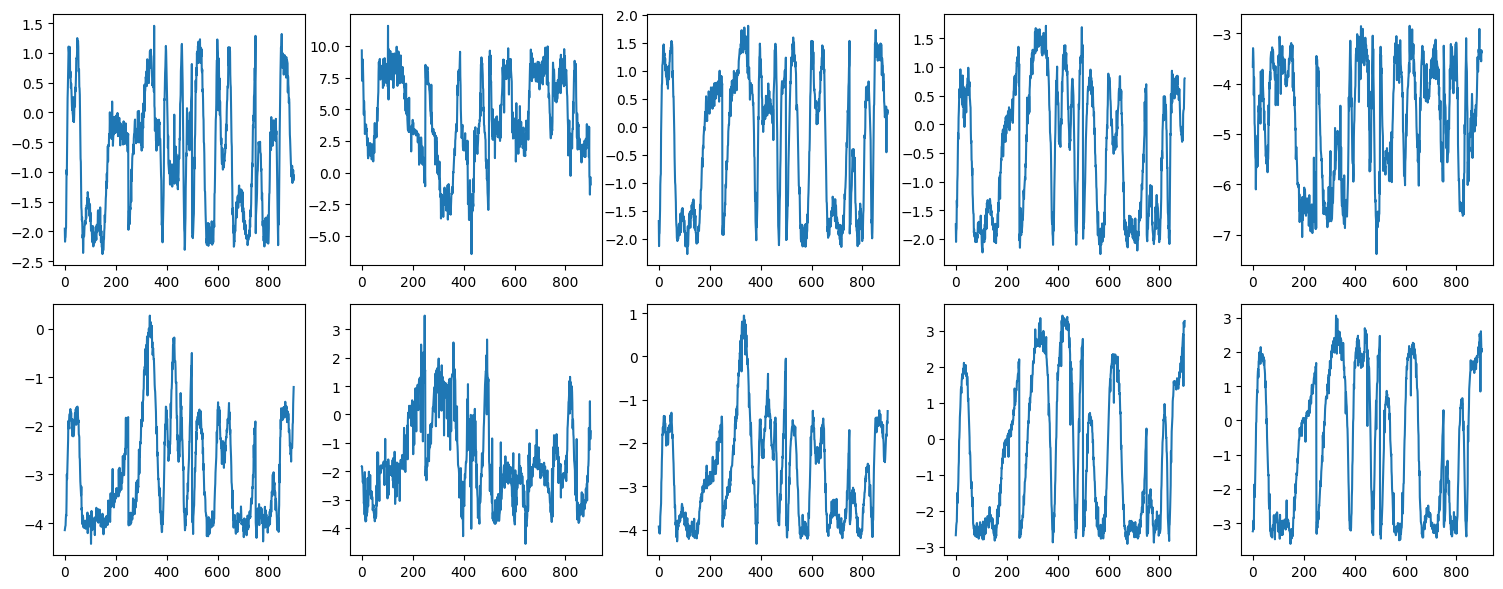

In [18]:
#iterative imputer 

train_df = pd.read_csv("train.csv")
train_df['season']=train_df['season'].map({'spring':0.0, 'summer':1.0, 'autumn':2.0, 'winter':3.0})

imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(train_df)
train_df = imp.transform(train_df)

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()

train_df = train_df[:, 1:]

for i in range(10):
    axs[i].plot(train_df[:, i])
    
plt.tight_layout()
plt.show()

[MatrixFactorization] Iter 10: observed MAE=0.419042 rank=40
[MatrixFactorization] Iter 20: observed MAE=0.113323 rank=40
[MatrixFactorization] Iter 30: observed MAE=0.071351 rank=40
[MatrixFactorization] Iter 40: observed MAE=0.045579 rank=40
[MatrixFactorization] Iter 50: observed MAE=0.028627 rank=40


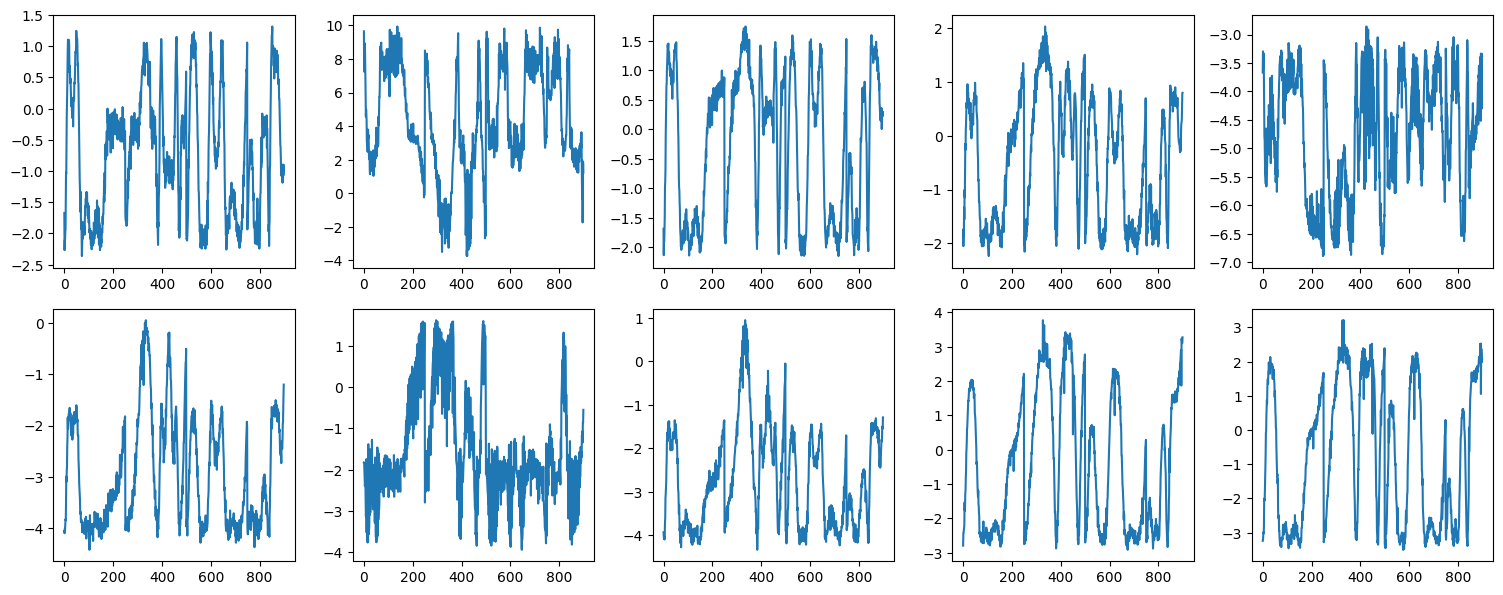

In [25]:
#matrixfactorization

train_df = pd.read_csv("train.csv")
train_df['season']=train_df['season'].map({'spring':0.0, 'summer':1.0, 'autumn':2.0, 'winter':3.0})

mf_model = MatrixFactorization()
train_df = mf_model.fit_transform(train_df)

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()

train_df = train_df[:, 1:]

for i in range(10):
    axs[i].plot(train_df[:, i])
    
plt.tight_layout()
plt.show()

# Modeling and Prediction
TODO: Define the model and fit it using training data. Then, use test data to make predictions

In [50]:
"""
This defines the model, fits training data and then does the prediction
with the test data 

Parameters
----------
X_train: matrix of floats, training input with 10 features
y_train: array of floats, training output
X_test: matrix of floats: dim = (100, ?), test input with 10 features

Compute
----------
y_test: array of floats: dim = (100,), predictions on test set
"""

gpr = GaussianProcessRegressor(kernel=DotProduct())

print(X_filled_knn.iloc[[1]])
print(X_filled_knn.drop('1'))
#remove swiss prices 
#y train are the swiss prices 
#gpr.fit(df_imputed, X_filled_knn[2])


        0         1         2         3         4         5         6    \
1  9.644028  7.246061  7.620085  8.411894  8.926884  8.104719  7.002749   

        7         8         9    ...       890       891       892       893  \
1  5.502236  4.574785 -0.854937  ...  2.679221  3.633928  0.324546  0.272197   

        894       895       896       897       898       899  
1 -0.303802  0.552046 -1.734754  0.636573  0.824886  0.707675  

[1 rows x 900 columns]


KeyError: "['1'] not found in axis"

In [ ]:

#what is X test 
predictions = gpr.predict(X_test)
print(X_test)
y_pred=np.zeros(X_test.shape[0])
#TODO: Define the model and fit it using training data. Then, use test data to make predictions

assert y_pred.shape == (100,), "Invalid data shape"

# Saving Results
You don't have to change this

In [ ]:
dt = pd.DataFrame(y_pred) 
dt.columns = ['price_CHF']
dt.to_csv('results.csv', index=False)
print("\nResults file successfully generated!")